<h1 align = "center">EEG Data Analysis</h1>

In [548]:
def get_outliers_iqr(df, iqr_mul=3):
    """
    Count outliers from pandas dataframe based on IQR indicator.
    :param df: Pandas dataFrame
    :param IQR_mul : IQR_mult > 1.5 - normal outliers, IQR_mul > 3 - extreme outliers
    :return df_out :
    """
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_outliers = df < (Q1 - iqr_mul * IQR)
    upper_outliers = df > (Q3 + iqr_mul * IQR)
    
    return lower_outliers,upper_outliers

# TODO : 

1. Wykonać analizę klastrów stymulanta wizualnego (Pokazać że niektóre klasy na siebie nachodzą)
2. Zrobić 3 części analizy : 
    * Analiza sygnału EEG
    * Analiza obrazu
    * Analiza EEG względem obrazu

# Introduction

## Data measurement

# EEG Analysis

## Import libraries

In [106]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

#path
import sys
sys.path.append("..")

import config

## Read data

In [75]:
filename = "mnist-64s.csv"
csv_path = os.path.join(config.RAW_EEG_DIR,filename)
csv_path

'/home/michal/Desktop/ML_Projects/eeg2image/data/raw/EEG/mnist-64s.csv'

In [76]:
df = pd.read_csv(csv_path,index_col=0)
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,mnist_index,mnist_class
0,4193.333008,4185.127930,4188.205078,4183.589844,4141.538574,4185.641113,4188.717773,4185.127930,4191.281738,4254.358887,4176.922852,4184.102539,4176.410156,4187.692383,0,5
1,4200.000000,4183.589844,4190.769043,4183.589844,4160.512695,4182.051270,4182.563965,4183.589844,4192.307617,4238.461426,4184.102539,4186.153809,4173.846191,4178.461426,0,5
2,4190.769043,4189.743652,4187.692383,4188.717773,4178.461426,4190.256348,4188.717773,4176.410156,4190.256348,4245.127930,4176.410156,4184.615234,4174.871582,4171.281738,0,5
3,4180.512695,4182.563965,4187.179199,4180.512695,4177.948730,4183.589844,4181.025391,4182.051270,4187.179199,4284.102539,4177.948730,4185.641113,4179.487305,4176.410156,0,5
4,4186.666504,4184.102539,4189.743652,4185.127930,4187.692383,4185.641113,4184.102539,4198.974121,4189.230469,4273.333008,4189.230469,4188.205078,4183.076660,4182.051270,0,5


## How many observations we have ? 

In [73]:
print("Number of observations : ",df.shape[0])
print("Number of features : ",df.shape[1])

Number of observations :  76800
Number of features :  16


## How many images was presented during experiment ?

In [93]:
len(df.mnist_index.unique())

1200

## How many class our data have ? 

In [94]:
len(df.mnist_class.unique())

10

## What is the sampling frequency per visual stimulus ?

In [101]:
sampling = len(df[df.mnist_index == 0])
sampling

64

## Does all eeg batch contain 64 samples?

In [117]:
def check_eeg_sampling(df):
    feedback = {}
    for index in df.mnist_index:
        sample_len = len(df[df.mnist_index == 0]["mnist_index"]) # filtering
        if sample_len != sampling :
            feedback[str(index)] = sample_len
            
    return feedback

In [119]:
error_batch = check_eeg_sampling(df)
len(error_batch)

0

## How many samples our data provides per class? 

In [153]:
pd.DataFrame(df["mnist_class"].value_counts().sort_index()).T

,0,1,2,3,4,5,6,7,8,9
mnist_class,7488,9152,7616,7104,8256,6656,7040,9088,6656,7744


## Mean number of samples per class?

In [172]:
df["mnist_class"].value_counts().mean()

7680.0

##  Difference between sampling the most and the lowest represented class ?

In [157]:
lowest_samples = df["mnist_class"].value_counts().sort_index().min()
highest_samples = df["mnist_class"].value_counts().sort_index().max()

In [158]:
print(lowest_samples)
print(highest_samples)

6656
9152


In [171]:
print("Najmniej liczna klasa ma około {} % mniej próbek od najbardziej licznej klasy".format(round(100 - (6656*100)/9152),2))

Najmniej liczna klasa ma około 27 % mniej próbek od najbardziej licznej klasy


# Check summary statistics

In [173]:
df.describe(include="all")

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,mnist_index,mnist_class
count,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.00000
mean,4187.201069,4186.863044,4186.256877,4186.797570,4187.187587,4186.359638,4186.542157,4187.210165,4188.594993,4187.815484,4186.813654,4181.925026,4187.069658,4187.014156,599.500000,4.43750
std,36.799726,14.131410,33.108191,20.937706,21.116343,13.565859,14.907183,15.156324,2.350475,28.182697,24.635612,19.545867,24.966641,28.358797,346.412297,2.89071
min,4006.666504,4152.307617,3849.743408,3994.358887,4000.512695,4154.358887,4152.307617,4012.307617,4179.487305,3952.307617,3977.948730,3978.461426,4025.640869,3889.743408,0.000000,0.00000
25%,4170.769043,4176.410156,4174.358887,4177.436035,4175.384277,4176.410156,4175.384277,4177.948730,4187.179199,4173.333008,4175.897461,4170.256348,4175.897461,4173.846191,299.750000,2.00000
50%,4185.127930,4186.666504,4187.179199,4186.666504,4187.179199,4186.153809,4186.666504,4186.666504,4188.717773,4187.692383,4186.666504,4181.538574,4186.153809,4186.153809,599.500000,4.00000
75%,4198.974121,4197.948730,4200.512695,4195.897461,4199.487305,4196.922852,4198.461426,4197.436035,4190.256348,4201.538574,4197.436035,4192.820312,4196.410156,4197.948730,899.250000,7.00000
max,4741.538574,4231.281738,4433.846191,4719.487305,4416.410156,4223.076660,4230.256348,4309.230469,4205.127930,4704.102539,4586.666504,4327.692383,4429.230469,4425.127930,1199.000000,9.00000


### Mean and std deviation are interesting...

In [183]:
df.groupby(["mnist_class"]).agg(["mean","std"])

AF3                      F7                      F3  \
                    mean        std         mean        std         mean   
mnist_class                                                                
0            4182.323822  31.032862  4186.876341  13.876190  4186.949276   
1            4189.564351  44.187193  4187.008655  14.089030  4188.339004   
2            4188.332693  35.024958  4186.847970  14.584678  4186.260066   
3            4184.494444  26.761378  4186.761569  13.771213  4186.773983   
4            4186.383884  25.088061  4186.822480  13.843281  4185.897770   
5            4186.029240  30.287435  4186.787531  14.591815  4186.369473   
6            4185.231687  26.912368  4186.844599  14.194752  4185.636774   
7            4188.857455  48.916671  4186.929638  13.820323  4185.289094   
8            4190.409170  50.060064  4186.823052  14.429845  4181.587364   
9            4189.461650  34.489289  4186.867156  14.251289  4188.648181   

                                FC5                      T7             ...  \
                   std         mean        std         mean        std  ...   
mnist_class                                                             ...   
0            33.169663  4186.479465  27.077026  4187.549755  20.143246  ...   
1            30.760011  4186.401807  19.531373  4187.847871  21.367808  ...   
2            29.788773  4186.436686  13.490329  4186.301074  17.615995  ...   
3            38.296087  4189.394393  37.784854  4186.710093  19.517037  ...   
4            36.869864  4185.368427  14.848916  4188.235155  23.560923  ...   
5            32.635648  4187.070674  13.380219  4187.102882  28.059889  ...   
6            27.220390  4186.152579  20.211982  4186.442936  19.959208  ...   
7            31.473379  4186.884043  21.446499  4186.483909  18.388310  ...   
8            42.829734  4187.636271  14.082300  4185.975463  21.081125  ...   
9            25.743378  4186.598491  14.808169  4188.867510  20.460635  ...   

                     FC6                      F4                      F8  \
                    mean        std         mean        std         mean   
mnist_class                                                                
0            4189.478105  30.318683  4182.432098  21.293253  4189.329972   
1            4188.218472  25.322519  4183.975210  21.382100  4188.957226   
2            4187.688504  21.773810  4181.655657  18.652767  4186.476882   
3            4180.307132  25.213198  4179.234569  18.948342  4185.754621   
4            4189.052398  20.269866  4183.136950  18.217224  4187.803891   
5            4186.415395  21.972932  4181.852404  18.087343  4186.748697   
6            4183.965372  30.275550  4180.851299  19.241560  4187.018035   
7            4183.941869  20.393364  4180.196382  18.154790  4183.289389   
8            4189.015245  23.132284  4182.572630  18.944660  4186.912034   
9            4189.708262  24.605873  4182.963317  21.275690  4188.554483   

                                AF4            mnist_index              
                   std         mean        std        mean         std  
mnist_class                                                             
0            28.569041  4188.233109  29.644375  588.452991  354.301388  
1            26.558748  4188.831428  36.478589  576.216783  357.791326  
2            23.240880  4187.941818  26.058208  588.831933  335.497791  
3            25.914215  4185.408480  24.000534  579.279279  360.099867  
4            24.683224  4187.632081  21.778856  621.302326  356.945721  
5            22.687455  4184.808055  28.057158  600.211538  312.482508  
6            24.795586  4184.936597  30.440732  601.463636  351.495426  
7            21.534558  4186.923146  26.689604  639.964789  342.480137  
8            23.253370  4185.368643  28.269978  614.644231  324.367844  
9            26.867504  4188.895655  28.063867  580.595041  351.454583  

[10 rows x 30 columns]

In [251]:
df.groupby(["mnist_class"]).agg(["mean","std"]).diff()[df.columns[0:14]]

AF3                   F7                  F3             \
                 mean        std      mean       std      mean        std   
mnist_class                                                                 
0                 NaN        NaN       NaN       NaN       NaN        NaN   
1            7.240529  13.154331  0.132314  0.212840  1.389728  -2.409652   
2           -1.231657  -9.162235 -0.160685  0.495648 -2.078938  -0.971238   
3           -3.838249  -8.263580 -0.086401 -0.813465  0.513916   8.507315   
4            1.889440  -1.673317  0.060910  0.072068 -0.876213  -1.426223   
5           -0.354644   5.199374 -0.034949  0.748534  0.471703  -4.234216   
6           -0.797552  -3.375067  0.057068 -0.397064 -0.732700  -5.415258   
7            3.625767  22.004303  0.085039 -0.374428 -0.347679   4.252988   
8            1.551715   1.143393 -0.106585  0.609522 -3.701730  11.356356   
9           -0.947520 -15.570775  0.044103 -0.178557  7.060817 -17.086357   

                  FC5                   T7            ...        T8  \
                 mean        std      mean       std  ...      mean   
mnist_class                                           ...             
0                 NaN        NaN       NaN       NaN  ...       NaN   
1           -0.077658  -7.545653  0.298116  1.224562  ... -0.000374   
2            0.034879  -6.041044 -1.546797 -3.751813  ... -0.098625   
3            2.957707  24.294525  0.409019  1.901042  ...  1.169438   
4           -4.025966 -22.935939  1.525062  4.043885  ...  0.547387   
5            1.702247  -1.468697 -1.132273  4.498966  ... -1.839233   
6           -0.918095   6.831763 -0.659946 -8.100681  ... -0.821447   
7            0.731464   1.234517  0.040974 -1.570898  ... -2.379840   
8            0.752229  -7.364199 -0.508446  2.692815  ...  2.906353   
9           -1.037780   0.725869  2.892047 -0.620490  ... -0.047302   

                             FC6                  F4                  F8  \
                   std      mean       std      mean       std      mean   
mnist_class                                                                
0                  NaN       NaN       NaN       NaN       NaN       NaN   
1             2.705669 -1.259633 -4.996164  1.543112  0.088847 -0.372746   
2             8.356199 -0.529968 -3.548709 -2.319553 -2.729333 -2.480344   
3            -9.901543 -7.381372  3.439388 -2.421089  0.295574 -0.722261   
4            10.203749  8.745266 -4.943332  3.902381 -0.731118  2.049270   
5           -14.644355 -2.637003  1.703066 -1.284545 -0.129881 -1.055194   
6             2.984960 -2.450024  8.302618 -1.001105  1.154217  0.269338   
7            -1.644676 -0.023503 -9.882187 -0.654918 -1.086770 -3.728646   
8            -0.152283  5.073377  2.738920  2.376248  0.789870  3.622645   
9             0.637833  0.693017  1.473589  0.390687  2.331029  1.642448   

                            AF4             
                  std      mean        std  
mnist_class                                 
0                 NaN       NaN        NaN  
1           -2.010293  0.598319   6.834215  
2           -3.317868 -0.889610 -10.420381  
3            2.673335 -2.533338  -2.057674  
4           -1.230992  2.223601  -2.221678  
5           -1.995768 -2.824026   6.278302  
6            2.108131  0.128542   2.383574  
7           -3.261028  1.986548  -3.751128  
8            1.718812 -1.554503   1.580373  
9            3.614134  3.527012  -0.206110  

[10 rows x 28 columns]

As we can see there is very small diference between sensor values per image class  
It means that it can be very diffucult to model data with very low differentiation in sensors values per class

# Check missing data

In [34]:
print(f"Number of missing data : {df.isna().sum().sum()}")
pd.DataFrame(df.isna().sum()).T

Number of missing data : 0


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Na podstawie danych ktore otrzymalem nie stwierdza sie braku ich danych i koniecznosci ich uzupelniania 

# Check possible outliers 

https://towardsdatascience.com/outliers-analysis-a-quick-guide-to-the-different-types-of-outliers-e41de37e6bf6

In [192]:
pd.DataFrame({"mean": df.mean(),"median" : df.median(), "diff" : df.mean()-df.median()})

,mean,median,diff
AF3,4187.201069,4185.127930,2.073139
F7,4186.863044,4186.666504,0.196540
F3,4186.256877,4187.179199,-0.922322
FC5,4186.797570,4186.666504,0.131066
T7,4187.187587,4187.179199,0.008388
P7,4186.359638,4186.153809,0.205829
O1,4186.542157,4186.666504,-0.124347
O2,4187.210165,4186.666504,0.543661
P8,4188.594993,4188.717773,-0.122781
T8,4187.815484,4187.692383,0.123101


As wee can se there difference between mean and median is very low.
It means that : 

 * There is a lot of outliers with low difference between normal data
 * There is a few samples of outliers with high value
 
Moja hipoteza wskazuje na to że outliery są w danych ale mają małą wartość względem 

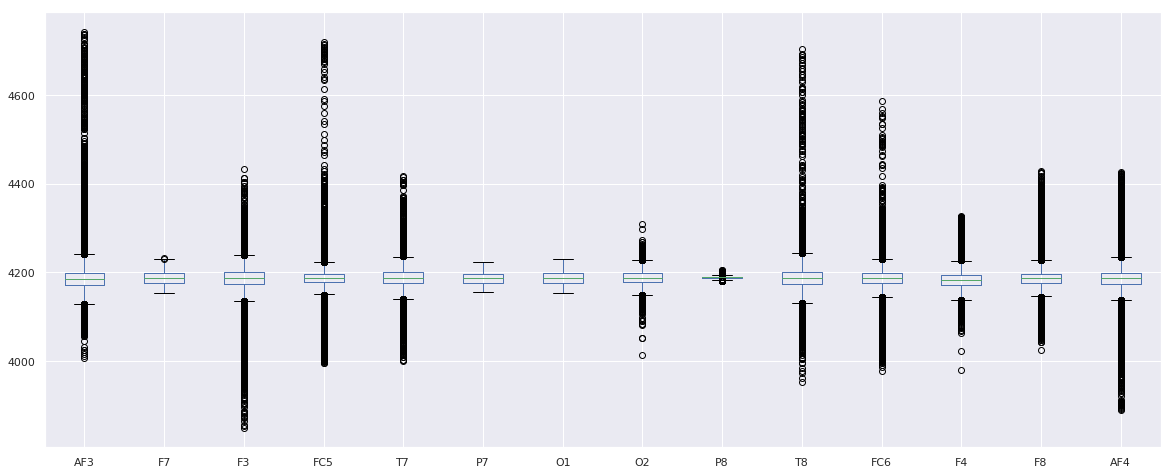

In [297]:
_ = df[df.columns[0:14]].boxplot(figsize=(20,8))

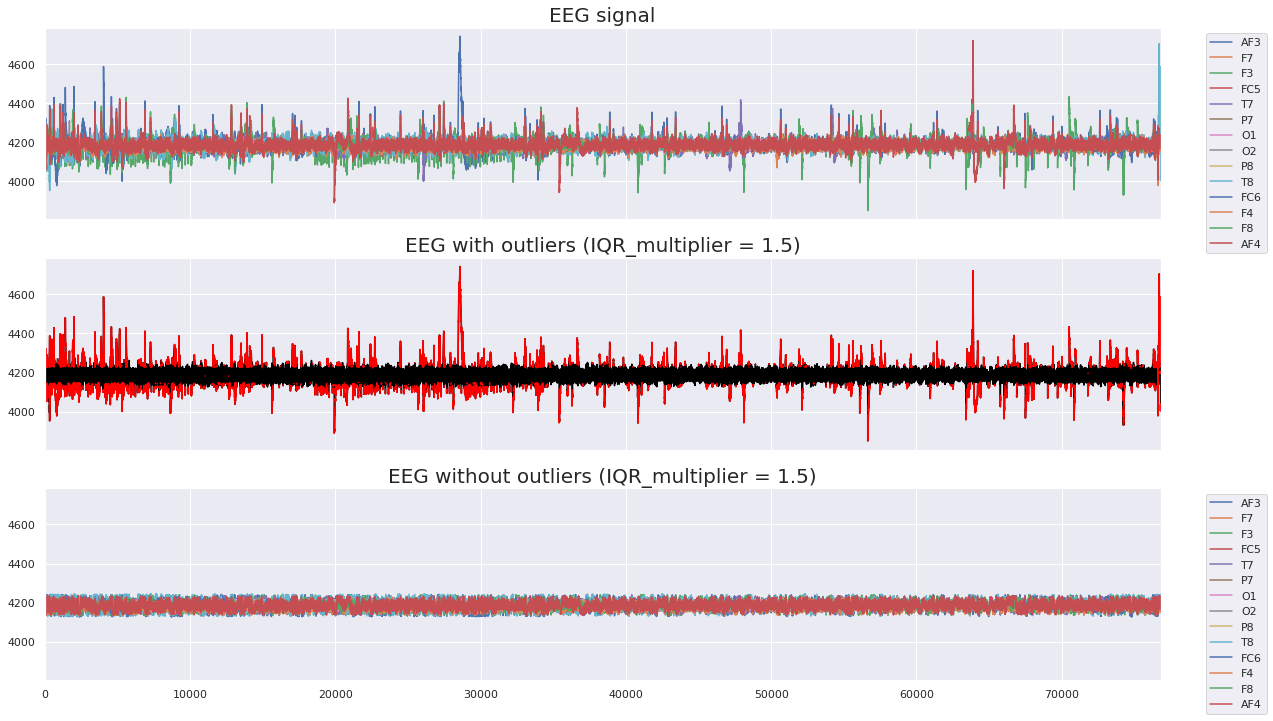

In [618]:
# Refactor 

fig,axes = plt.subplots(3,1,figsize=(20,12),sharex=True)

# Plot EEG signal 
_ = df[df.columns[0:14]].plot(grid=True,ax=axes[0]).legend(bbox_to_anchor=(1.1,1.0))
_ = axes[0].set_title("EEG signal",size=20)

# Plot EEG with outliers
IQR_MUL = 1.5
lower_outliers,upper_outliers = get_outliers_iqr(df,iqr_mul=IQR_MUL)
_ = df[df.columns[0:14]].plot(grid=True,color = "black",ax = axes[1],legend=False)
_ = df[df.columns[0:14]][lower_outliers | upper_outliers ].plot(color = "red",ax = axes[1],legend = False)
_ = axes[1].set_title(f"EEG with outliers (IQR_multiplier = {IQR_MUL})",size=20)

# Plot EEG without outliers
_ = df[df.columns[0:14]][(~upper_outliers & ~lower_outliers)].plot(ax = axes[2]).legend(bbox_to_anchor=(1.1,1.0))
_ = axes[2].set_title(f"EEG without outliers (IQR_multiplier = {IQR_MUL})",size=20)
down, up = axes[1].get_ylim() 
_ = axes[2].set_ylim(down,up)
#_ = df[df.columns[0:14]][~lower_outliers].plot(color = "red",ax = axes[2],legend = False)

# wnioski (Potlumaczyc)

* Srednia i mediana sa na bardzo podobnym poziomie w zwiazku z czym mozna powiedziec ze jezeli wystepuja outliery to sa marginalny czas trwania zbieranych danych 

* Na podstawie IQR można zauważyć że 50% danych charakteryzuje się bardzo małą zmiennością

* Mediana wszystkich eleketrod znajduje sie w niemal identycznym punkcie 

* Odchylenie standardowe w stosunku do sredniej wartosci calego przebiegu jest bardzo male. Moze to swiadczyc o niskim wplywie bodzcow na mozg dla danego urzadzenia

* Elektrody F7,P7,01,P8cechuja sie bardzo małą zmiennością z faktu ich uszkodzenia

As we can see there is a lot of spikes in eeg signal. These spikes probably are corelated with signal artifats(noise) related with 4 ex. closing eyes. This type of the anomaly is named **global anomaly**.

**global anomaly** - values are clearly outside the normal global range.

## Sprawdzić prawdopodobiestwo wystapienia outliera

## Zwizualizować wystąpienie outliera 
https://towardsdatascience.com/outliers-analysis-a-quick-guide-to-the-different-types-of-outliers-e41de37e6bf6

# Check distributions of Electrodes

In [120]:
#_ = df[df.columns[0:14]].hist(figsize=(15,15))

In [121]:
#_ = df[df.columns[0:14]].plot(figsize=(15,5),grid=True)

Na podstawie histogramu sygnalow EEG mozna stwierdzic ze wiekszosc danych pobranych z okreslonych czujnikow potwierdza zalozenie "central limit theorem" i w mniejszym lub wiekszym stopniu dąży do rozkładu normalnego.

W pozniejszym kroku mozna wykorzystać Power Transform zeby przyblizyc dane do rozkladu normanego. 

Z faktu że będziemy wykorzystywać model Variancyjnego autoenkodera nie ma potrzeby usuwania outlierow(artefaktow biologicznych) z sygnalu EEG.
VAE w warswie kompresji w iteratywnym procesie uczenia 

# Check corelation between sensors

<img src="../reports/figures/sensors2.png" style="height:250px" align = "center" >

In [37]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

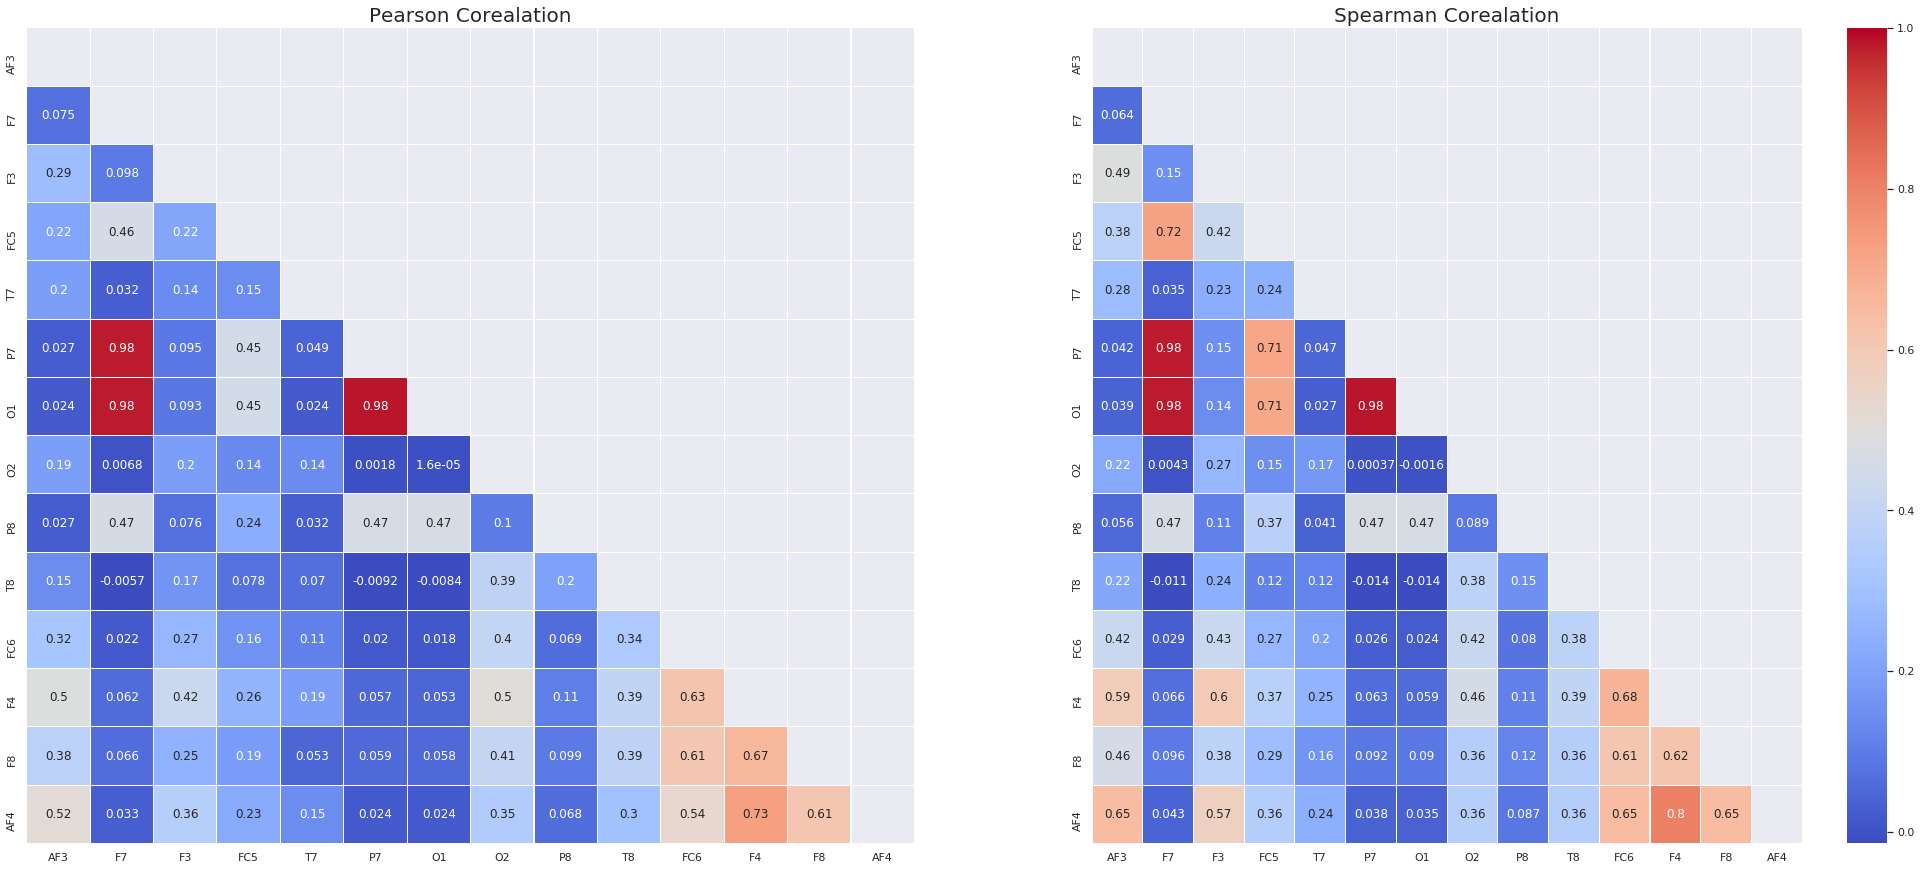

In [579]:
figure,axes = plt.subplots(1,2,figsize=(35,15))


# Pearson corelation 
corr = df[df.columns[0:14]].corr()
# Generate mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# plot heatmap
heatmap = sns.heatmap(corr,
                      square=False,
                      mask=mask,
                      linewidths=0.1,
                      cmap="coolwarm",
                      annot=True,
                      ax=axes[0],
                      cbar=False)
_ = heatmap.set_title("Pearson Corealation",size = 20)


# Spearman corelation
corr = df[df.columns[0:14]].corr(method="spearman")
#Generate mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#plot heatmap
_ = heatmap = sns.heatmap(corr,
                      square=False,
                      mask=mask,
                      linewidths=0.1,
                      cmap="coolwarm",
                      annot=True,
                      ax=axes[1])
_ = heatmap.set_title("Spearman Corealation",size=20)

# Corelation type
* **Pearson** - linear correlation
* **Spearman** - monotonic correlation

### Linear higly correlated features : 
* P7 - F7

* O1 - F7
* O1 - P7
* F4 - AF4


### Monotic highly correlated features : 
* AF4 - AF3
* AF3- F4
* F4 - F3
* F4 - FC6

## Plot correlated features

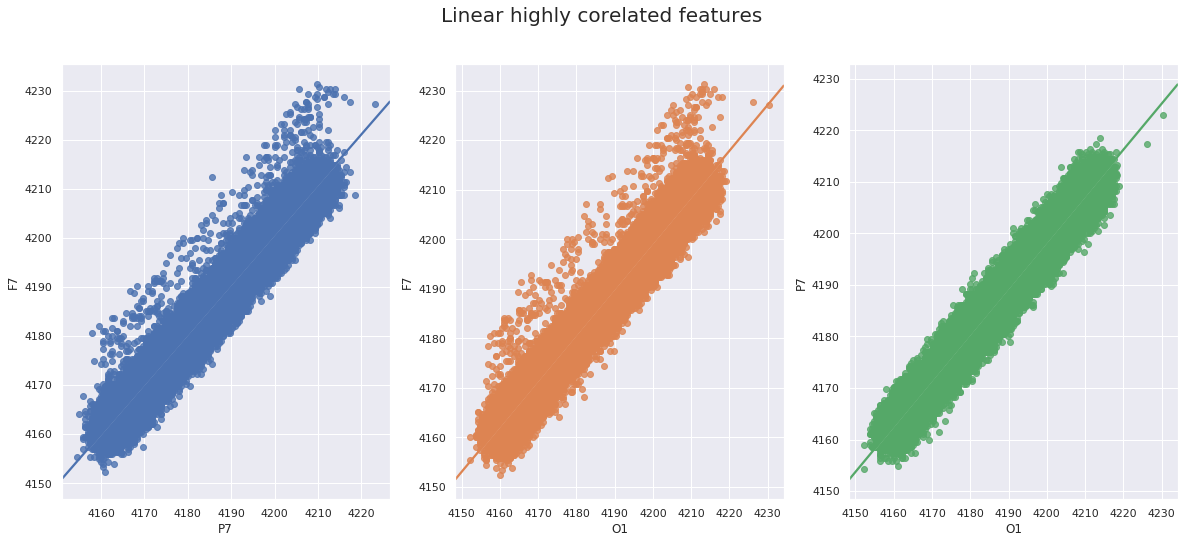

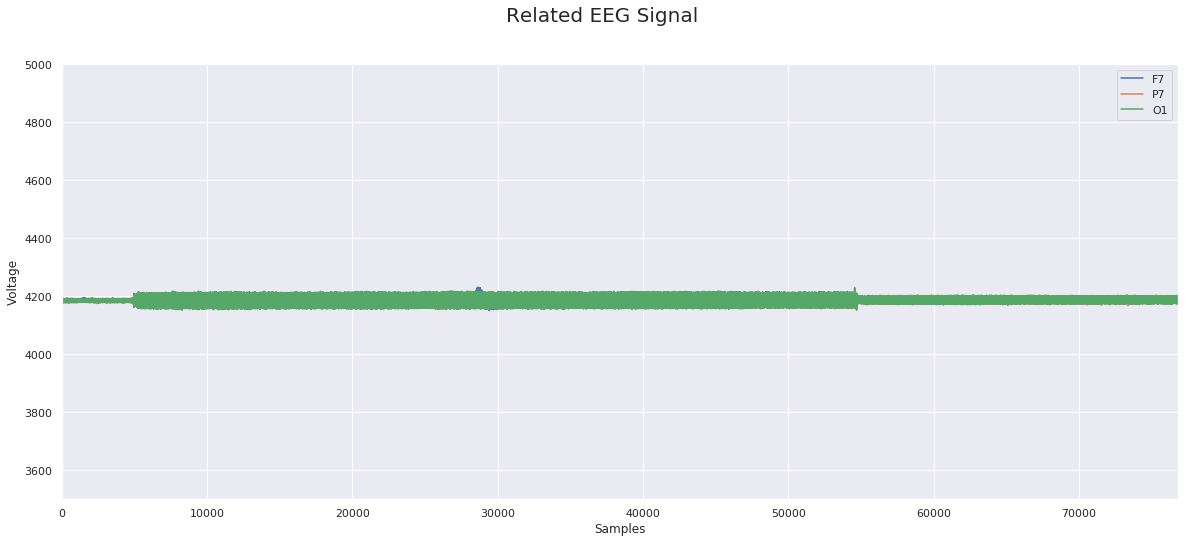

In [581]:
fig,axes = plt.subplots(1,3,figsize=(20,8))

sns.regplot(x="P7", y="F7", data=df,ax=axes[0])
sns.regplot(x="O1", y="F7", data=df,ax=axes[1])
sns.regplot(x="O1", y="P7", data=df,ax=axes[2])

_ = plt.suptitle("Linear highly corelated features",size = 20)


# plot 
_ = df[["F7","P7","O1"]].plot(figsize=(20,8),grid=True)
_ = plt.suptitle("Related EEG Signal",size = 20)
_ = plt.xlabel("Samples")
_ = plt.ylabel("Voltage")
_ = plt.ylim(3500,5000)

As we can see on image above there is very high corelation between these features.
Due to very low variance I think that **these sensors don't work correctly**(they don't have outliers related with bio artifacts)

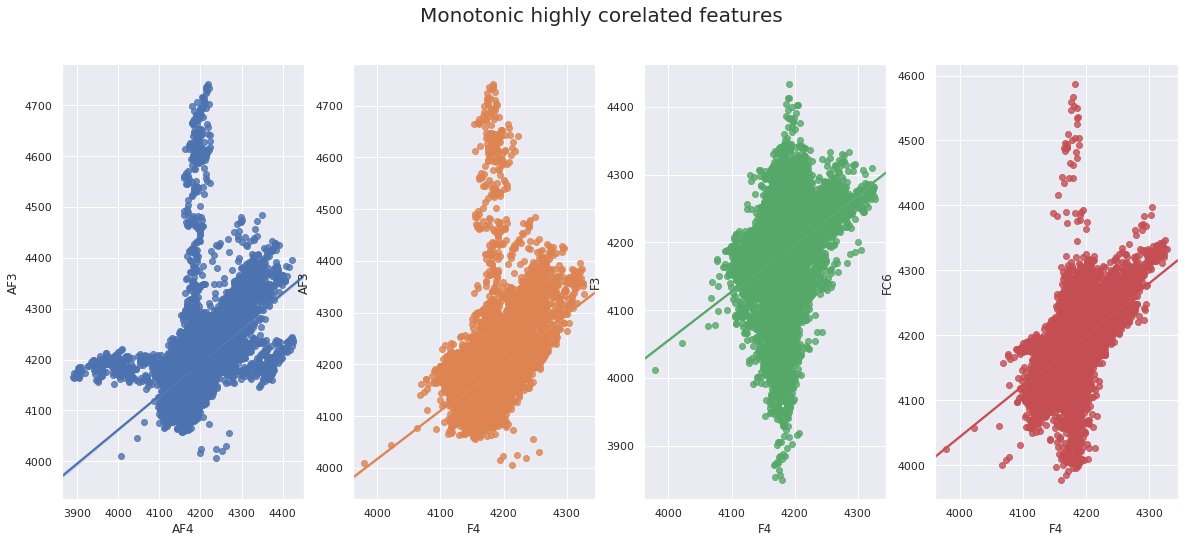

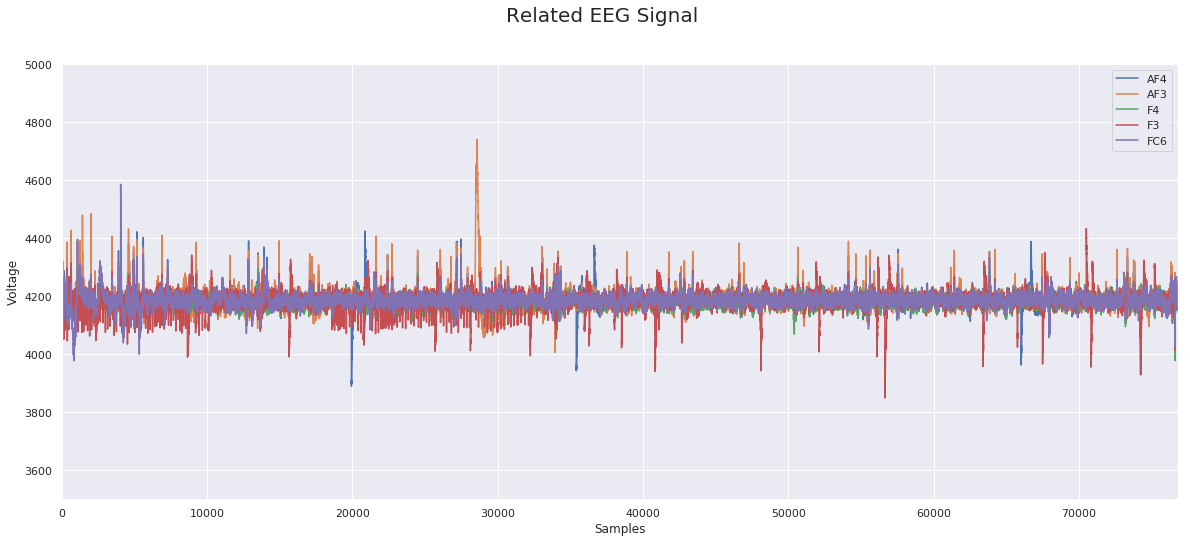

In [582]:
fig,axes = plt.subplots(1,4,figsize=(20,8))

sns.regplot(x="AF4", y="AF3", data=df,ax=axes[0])
sns.regplot(x="F4", y="AF3", data=df,ax=axes[1])
sns.regplot(x="F4", y="F3", data=df,ax=axes[2])
sns.regplot(x="F4", y="FC6",data=df,ax=axes[3])

_ = plt.suptitle("Monotonic highly corelated features",size = 20)

_ = df[["AF4","AF3","F4","F3","FC6"]].plot(figsize=(20,8),grid=True)
_ = plt.suptitle("Related EEG Signal",size = 20)
_ = plt.xlabel("Samples")
_ = plt.ylabel("Voltage")
_ = plt.ylim(3500,5000)

* [Przetlumaczyc normalnie - te rozbryski spowodowane sa outlierami(artefaktami) biologicznymi ktore widac wyraznie również na sygnale

* Ciężko jest powiedzieć czy korelacja faktycznie wywołana jest bodżcem zewnętrznym czy może związana jest z sposobem pomiaru sygnalu elektrycznego - referencja 

In [56]:
import seaborn as sns

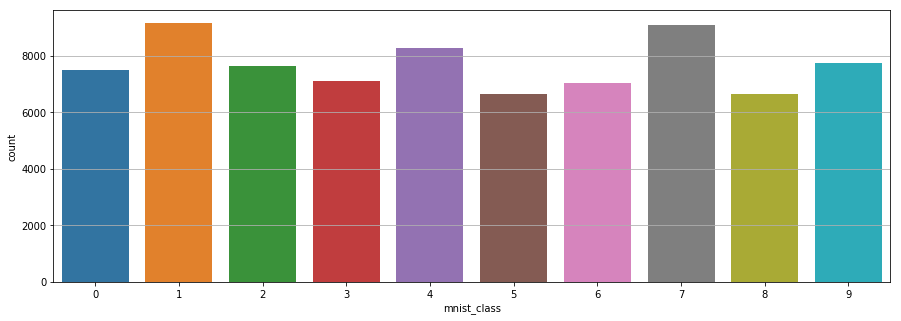

In [54]:
# To przeniesc wtedy gdy chcemy sprawdzić po grupowaniu ile jest probek
_ = plt.figure(figsize=(15,5))
plt.grid()
_ = sns.countplot(df.mnist_class)

# Check class distribution

# Feature dependence

**Stochastic dependence** 

Rodzaj zależności między zmiennymi, który polega na tym, że wraz ze zmianą wartości jednej zmiennej zmienia się rozkład prawdopodobieństwa drugiej zmiennej Zależność jest stochastyczna, jeżeli mamy do czynienia z wpływem na zmienną objaśnianą wielu innych niezidentyfikowanych zmiennych (poza samą zmienną).

**Corelation depencence**

Szczególny przypadek zależności stochastycznej, który charakteryzuje się tym, że określonym wartościom jednej zmiennej (zmiennej niezależnej) odpowiadają ściśle określone warunkowe średnie drugiej zmiennej (zmiennej zależnej).



#### Check dependency between features and class label

In [34]:
print("Mean and std for reach class : ")
df.groupby("mnist_class").agg(["mean","std"])

Mean and std for reach class : 


AF3                      F3                     FC5  \
                    mean        std         mean        std         mean   
mnist_class                                                                
0            4184.855877  30.521213  4182.246705  37.205920  4186.852575   
1            4192.889975  54.456643  4190.002151  28.366340  4185.070561   
2            4187.348466  41.593141  4186.800561  28.393474  4186.445845   
3            4185.744584  29.078624  4183.415164  39.419350  4188.000954   
4            4186.320089  26.654295  4189.574973  31.740712  4185.449612   
5            4187.223414  31.161394  4184.845057  39.939654  4186.937403   
6            4185.480088  35.335418  4187.933759  26.775010  4189.162125   
7            4188.347285  42.356049  4184.453844  30.626001  4186.867507   
8            4184.499789  33.012814  4185.060922  30.450466  4187.396657   
9            4187.351698  26.582416  4187.033897  36.258864  4186.612861   

                                 T7                      O2             ...  \
                   std         mean        std         mean        std  ...   
mnist_class                                                             ...   
0            19.693940  4188.690728  18.611798  4188.003888  15.467473  ...   
1            22.226876  4185.855905  22.973451  4187.064861  14.750632  ...   
2            13.240094  4184.683087  20.280196  4187.009367  15.047666  ...   
3            22.448738  4187.617494  18.735611  4186.569186  15.678050  ...   
4            16.151798  4189.225950  25.838503  4187.015096  15.150077  ...   
5            13.946994  4189.471798  19.022419  4186.519014  14.253081  ...   
6            38.541501  4183.997785  22.004384  4187.872134  16.296568  ...   
7            21.348615  4186.759109  20.184510  4186.795902  15.282623  ...   
8            13.714906  4187.799381  18.484128  4187.497051  15.165830  ...   
9            15.731634  4188.146487  21.706309  4187.835248  14.372567  ...   

                     FC6                      F4                      F8  \
                    mean        std         mean        std         mean   
mnist_class                                                                
0            4185.742010  23.158549  4182.777200  20.939717  4187.660223   
1            4186.634456  28.327011  4182.885495  20.444807  4187.980366   
2            4188.155538  19.594219  4181.483415  17.294536  4186.749521   
3            4183.459414  23.863480  4180.350009  20.518166  4185.413534   
4            4189.754358  28.403252  4182.219637  17.856933  4186.147410   
5            4186.932973  21.645730  4182.271928  18.852783  4186.587073   
6            4185.712896  30.257314  4182.010534  21.647434  4189.895953   
7            4185.247000  23.543109  4181.344811  19.700684  4185.999809   
8            4187.114820  23.037541  4182.863945  18.871764  4187.789978   
9            4189.164113  20.403318  4181.024016  18.734320  4186.710141   

                                AF4            mnist_index              
                   std         mean        std        mean         std  
mnist_class                                                             
0            25.733019  4187.514346  27.330771  588.452991  354.301388  
1            26.202967  4189.377250  29.306021  580.481389  360.252179  
2            21.109069  4184.855736  25.472141  588.831933  335.497791  
3            26.844411  4188.464904  31.914603  579.279279  360.099867  
4            22.868170  4186.964906  21.828642  621.302326  356.945721  
5            22.968774  4185.270136  35.709295  605.946913  308.387188  
6            29.473578  4187.477681  27.320116  601.463636  351.495426  
7            24.284787  4186.783711  27.094337  639.964789  342.480137  
8            26.233086  4186.276870  31.299046  614.644231  324.367844  
9            23.058910  4186.530484  25.833245  580.595041  351.454583  

[10 rows x 24 columns]

In [35]:
print("Mean and std difference for reach class : ")
df.groupby("mnist_class").agg(["mean","std"]).diff()

Mean and std difference for reach class : 


AF3                   F3                  FC5             \
                 mean        std      mean        std      mean        std   
mnist_class                                                                  
0                 NaN        NaN       NaN        NaN       NaN        NaN   
1            8.034098  23.935430  7.755447  -8.839580 -1.782014   2.532936   
2           -5.541508 -12.863502 -3.201590   0.027134  1.375284  -8.986782   
3           -1.603882 -12.514517 -3.385398  11.025876  1.555108   9.208644   
4            0.575505  -2.424329  6.159809  -7.678637 -2.551341  -6.296940   
5            0.903325   4.507099 -4.729917   8.198942  1.487791  -2.204803   
6           -1.743326   4.174024  3.088703 -13.164645  2.224722  24.594507   
7            2.867198   7.020631 -3.479915   3.850991 -2.294619 -17.192886   
8           -3.847496  -9.343235  0.607078  -0.175534  0.529150  -7.633708   
9            2.851908  -6.430398  1.972975   5.808398 -0.783796   2.016728   

                   T7                  O2            ...       FC6            \
                 mean       std      mean       std  ...      mean       std   
mnist_class                                          ...                       
0                 NaN       NaN       NaN       NaN  ...       NaN       NaN   
1           -2.834824  4.361653 -0.939027 -0.716840  ...  0.892447  5.168462   
2           -1.172818 -2.693255 -0.055493  0.297033  ...  1.521081 -8.732792   
3            2.934407 -1.544585 -0.440181  0.630384  ... -4.696124  4.269261   
4            1.608455  7.102893  0.445910 -0.527973  ...  6.294944  4.539772   
5            0.245848 -6.816084 -0.496083 -0.896996  ... -2.821385 -6.757522   
6           -5.474013  2.981964  1.353120  2.043487  ... -1.220078  8.611583   
7            2.761324 -1.819873 -1.076231 -1.013945  ... -0.465896 -6.714205   
8            1.040271 -1.700383  0.701149 -0.116793  ...  1.867821 -0.505568   
9            0.347107  3.222181  0.338197 -0.793263  ...  2.049293 -2.634223   

                   F4                  F8                 AF4             \
                 mean       std      mean       std      mean        std   
mnist_class                                                                
0                 NaN       NaN       NaN       NaN       NaN        NaN   
1            0.108295 -0.494909  0.320143  0.469948  1.862904   1.975250   
2           -1.402080 -3.150271 -1.230845 -5.093898 -4.521514  -3.833880   
3           -1.133405  3.223629 -1.335987  5.735343  3.609168   6.442462   
4            1.869628 -2.661233  0.733876 -3.976241 -1.499999 -10.085961   
5            0.052291  0.995850  0.439663  0.100604 -1.694770  13.880653   
6           -0.261394  2.794651  3.308880  6.504804  2.207545  -8.389179   
7           -0.665723 -1.946750 -3.896144 -5.188791 -0.693970  -0.225779   
8            1.519135 -0.828920  1.790169  1.948299 -0.506841   4.204708   
9           -1.839929 -0.137444 -1.079837 -3.174176  0.253614  -5.465801   

            mnist_index             
                   mean        std  
mnist_class                         
0                   NaN        NaN  
1             -7.971602   5.950791  
2              8.350544 -24.754388  
3             -9.552653  24.602076  
4             42.023046  -3.154145  
5            -15.355412 -48.558533  
6             -4.483277  43.108238  
7             38.501152  -9.015289  
8            -25.320558 -18.112293  
9            -34.049189  27.086739  

[10 rows x 24 columns]

## Wniosek 

Poprawić wnioski względem zeszytu!!!

* Na podstawie różnych wartośći średniej i odchylenia standardowego dla poszczególnych klas można stwierdzić że istnieje zależność stochastyczna
* Patrząc jednak po różniach w wartościach średnich i std prawdopodobnie ta zależność istnieje w stopniu bardzo znikomym co może utrudnić modelowanie
* Różnice w wartościach średnich mogą być przez artefakty natury biologicznej(np mruganie) które powodują widoczne szpilki na sygnale



# Check stochastic independence

In [78]:
from scipy.stats import chi2

In [80]:
df_chi2_emipirical = df.groupby("mnist_class").mean()[df.columns[0:-2]]
df_chi2_emipirical

,AF3,F3,FC5,T7,O2,P8,T8,FC6,F4,F8,AF4
mnist_class,,,,,,,,,,,
0,4182.323822,4186.949276,4186.479465,4187.549755,4187.940469,4188.625038,4188.173800,4189.478105,4182.432098,4189.329972,4188.233109
1,4189.564351,4188.339004,4186.401807,4187.847871,4188.033342,4188.567385,4188.173426,4188.218472,4183.975210,4188.957226,4188.831428
2,4188.332693,4186.260066,4186.436686,4186.301074,4186.306935,4188.681074,4188.074801,4187.688504,4181.655657,4186.476882,4187.941818
3,4184.494444,4186.773983,4189.394393,4186.710093,4186.740200,4188.563066,4189.244239,4180.307132,4179.234569,4185.754621,4185.408480
4,4186.383884,4185.897770,4185.368427,4188.235155,4187.897374,4188.681745,4189.791627,4189.052398,4183.136950,4187.803891,4187.632081
5,4186.029240,4186.369473,4187.070674,4187.102882,4187.175304,4188.606118,4187.952393,4186.415395,4181.852404,4186.748697,4184.808055
6,4185.231687,4185.636774,4186.152579,4186.442936,4186.704521,4188.496830,4187.130946,4183.965372,4180.851299,4187.018035,4184.936597
7,4188.857455,4185.289094,4186.884043,4186.483909,4185.519552,4188.607517,4184.751107,4183.941869,4180.196382,4183.289389,4186.923146
8,4190.409170,4181.587364,4187.636271,4185.975463,4187.590894,4188.552188,4187.657459,4189.015245,4182.572630,4186.912034,4185.368643


In [81]:
df_chi2["sum"] = df_chi2_emipirical.sum(axis=1)
df_chi2.head()

,AF3,F3,FC5,T7,O2,P8,T8,FC6,F4,F8,AF4,sum
mnist_class,,,,,,,,,,,,
0,4182.323822,4186.949276,4186.479465,4187.549755,4187.940469,4188.625038,4188.173800,4189.478105,4182.432098,4189.329972,4188.233109,46057.514909
1,4189.564351,4188.339004,4186.401807,4187.847871,4188.033342,4188.567385,4188.173426,4188.218472,4183.975210,4188.957226,4188.831428,46066.909521
2,4188.332693,4186.260066,4186.436686,4186.301074,4186.306935,4188.681074,4188.074801,4187.688504,4181.655657,4186.476882,4187.941818,46054.156190
3,4184.494444,4186.773983,4189.394393,4186.710093,4186.740200,4188.563066,4189.244239,4180.307132,4179.234569,4185.754621,4185.408480,46042.625219
4,4186.383884,4185.897770,4185.368427,4188.235155,4187.897374,4188.681745,4189.791627,4189.052398,4183.136950,4187.803891,4187.632081,46059.881299


In [82]:
df_chi2.loc["ogolem"] = df_chi2.sum()
df_chi2.tail()

,AF3,F3,FC5,T7,O2,P8,T8,FC6,F4,F8,AF4,sum
mnist_class,,,,,,,,,,,,
6,4185.231687,4185.636774,4186.152579,4186.442936,4186.704521,4188.496830,4187.130946,4183.965372,4180.851299,4187.018035,4184.936597,46042.567576
7,4188.857455,4185.289094,4186.884043,4186.483909,4185.519552,4188.607517,4184.751107,4183.941869,4180.196382,4183.289389,4186.923146,46040.743462
8,4190.409170,4181.587364,4187.636271,4185.975463,4187.590894,4188.552188,4187.657459,4189.015245,4182.572630,4186.912034,4185.368643,46053.277361
9,4189.461650,4188.648181,4186.598491,4188.867510,4188.264364,4188.552483,4187.610158,4189.708262,4182.963317,4188.554483,4188.895655,46068.124552
ogolem,83742.176791,83723.501971,83736.845671,83743.033292,83744.345908,83771.866885,83757.119911,83735.581510,83637.741031,83741.690456,83737.958020,460535.930724


## Obliczanie liczebności teoretycznej

In [85]:
col = df_chi2["sum"][0:-1].values
col = col.reshape(df_chi2_emipirical.shape[0],1)
col

array([[46057.51490852],
       [46066.90952056],
       [46054.15618973],
       [46042.62521874],
       [46059.88129925],
       [46050.13063504],
       [46042.56757552],
       [46040.74346233],
       [46053.27736147],
       [46068.12455236]])

In [87]:
row = df_chi2.loc["ogolem"][0:-1].values
row=row.reshape(1,df_chi2_emipirical.shape[1])
row

array([[83742.17679102, 83723.50197133, 83736.84567127, 83743.03329227,
        83744.34590848, 83771.86688474, 83757.11991134, 83735.58150951,
        83637.74103111, 83741.69045647, 83737.95801951]])

In [95]:
n_obs =  df_chi2.loc["ogolem"][-1]
n_obs

460535.93072352593

In [91]:
df = col * row / n_obs

In [92]:
df_real_count = pd.DataFrame(df)
df_real_count

,0,1,2,3,4,5,6,7,8,9,10
0,8374.930812,8373.063171,8374.397654,8375.016469,8375.147742,8377.900074,8376.425251,8374.271227,8364.486346,8374.882174,8374.508898
1,8376.639094,8374.771072,8376.105827,8376.724768,8376.856068,8379.608961,8378.133838,8375.979375,8366.192498,8376.590446,8376.217094
2,8374.320074,8372.452570,8373.786956,8374.405725,8374.536989,8377.289120,8375.814405,8373.660538,8363.876371,8374.271440,8373.898192
3,8372.223325,8370.356287,8371.690340,8372.308954,8372.440185,8375.191627,8373.717281,8371.563953,8361.782236,8372.174703,8371.801548
4,8375.361107,8373.493370,8374.827923,8375.446769,8375.578049,8378.330522,8376.855623,8374.701489,8364.916105,8375.312467,8374.939173
5,8373.588082,8371.720741,8373.055010,8373.673726,8373.804978,8376.556868,8375.082282,8372.928604,8363.145291,8373.539452,8373.166237
6,8372.212843,8370.345808,8371.679859,8372.298473,8372.429703,8375.181141,8373.706797,8371.553473,8361.771767,8372.164221,8371.791067
7,8371.881153,8370.014192,8371.348190,8371.966779,8372.098004,8374.849334,8373.375048,8371.221809,8361.440491,8371.832533,8371.459393
8,8374.160271,8372.292802,8373.627163,8374.245921,8374.377182,8377.129260,8375.654573,8373.500748,8363.716767,8374.111638,8373.738397
9,8376.860031,8374.991959,8376.326750,8376.945708,8377.077011,8379.829977,8378.354814,8376.200294,8366.413159,8376.811382,8376.438020


In [96]:
chi2 = np.sum(np.square(df_chi2_emipirical.values)/df_real_count.values) - n_obs
chi2

-230267.939459613

In [98]:
from scipy.stats import chisquare

In [101]:
#liczba stopni swobody
n_degrees = (len(df_chi2_emipirical)-1) * (len(df_chi2_emipirical.columns)-1)
n_degrees

90

In [134]:
chisq , p = chisquare(df_chi2_emipirical.values,df_real_count.values,n_degrees,axis=None)

In [105]:
import math

In [108]:
def czuprov(chisq,n_obs,n_degrees):
    return math.sqrt(chisq/(n_obs*n_degrees))

In [136]:
T = czuprov(chisq,n_obs,n_degrees)
print(T)

0.07453560344213542


In [111]:
def coefficient_of_determination(value):
    return (value**2) * 100

In [131]:
print(f"Zależność stochastyczna pomiędzy obrazem a EEG wynosi {round(coefficient_of_determination(T),2)} %")
print("Oznacza to że w jedynie 0.5% sygnał EEG określa bodziec wizualny ")

Zależność stochastyczna pomiędzy obrazem a EEG wynosi 0.56 %
Oznacza to że w jedynie 0.5% sygnał EEG określa bodziec wizualny 


# Image Analysis 

During experiment I use mnist dataset containts handwritten digits between 0-9.

In [489]:
from keras.datasets import mnist
(x_train, y_train), (_,_) = mnist.load_data()
x_train = x_train[0:1202]
y_train = y_train[0:1202]

In [490]:
print("image shape : ",x_train[0].shape) 

image shape :  (28, 28)


## Check Data Visually

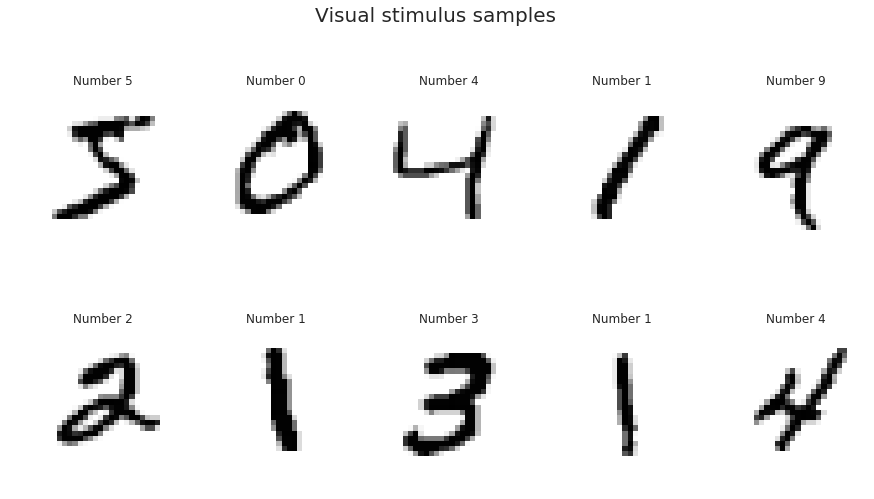

In [493]:
plt.figure(figsize=(15,8))
plt.suptitle("Visual stimulus samples",size = 20)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i],cmap=plt.cm.binary)
    plt.grid(False)
    plt.axis('off')
    plt.title(f"Number {y_train[i]}")

# ***********CZĘŚĆ Z PREPROCESSINGIEM****************

# Preprocessing do modelowania

In [41]:
df.head(5)

,AF3,F3,FC5,T7,O2,P8,T8,FC6,F4,F8,AF4,mnist_index,mnist_class
0,4193.333008,4188.205078,4183.589844,4141.538574,4185.127930,4191.281738,4254.358887,4176.922852,4184.102539,4176.410156,4187.692383,0,5
1,4200.000000,4190.769043,4183.589844,4160.512695,4183.589844,4192.307617,4238.461426,4184.102539,4186.153809,4173.846191,4178.461426,1,0
2,4190.769043,4187.692383,4188.717773,4178.461426,4176.410156,4190.256348,4245.127930,4176.410156,4184.615234,4174.871582,4171.281738,1,0
3,4180.512695,4187.179199,4180.512695,4177.948730,4182.051270,4187.179199,4284.102539,4177.948730,4185.641113,4179.487305,4176.410156,1,0
4,4186.666504,4189.743652,4185.127930,4187.692383,4198.974121,4189.230469,4273.333008,4189.230469,4188.205078,4183.076660,4182.051270,1,0


In [42]:
df = df.drop(labels="mnist_class",axis=1) # Drop mnist class

In [43]:
mnist_indexes = df.mnist_index.value_counts()

In [44]:
len(mnist_indexes)

1201

In [45]:
x_train = x_train[1:]

In [46]:
eeg_batched = [df[df["mnist_index"]==i].values for i in range(len(mnist_indexes))]

In [47]:
images_batched = [x_train[i] for i in range(len(mnist_indexes))]

In [54]:
df2 = pd.DataFrame({"eeg" : eeg_batched,
                   "img" : images_batched})
    

In [55]:
df2.head()

,eeg,img
0,"[[4193.333007812501, 4188.205078125, 4183.5898...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[4199.999999999999, 4190.76904296875, 4183.58...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[4220.0, 4205.1279296875, 4188.205078125, 418...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[4203.076660156249, 4107.6923828125, 4193.333...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[4220.0, 4160.512695312499, 4179.487304687501...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


# Test

In [56]:
import matplotlib.pyplot as plt

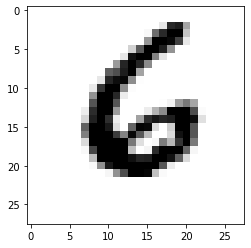

In [68]:
plt.imshow(df2.img.iloc[89],cmap=plt.cm.binary)

# Train-test-split

In [38]:
from sklearn.model_selection import train_test_split

In [61]:
X = df2.eeg.values
y = df2.img.values

In [64]:
X.shape

(1201,)

In [65]:
y.shape

(1201,)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [352]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

NameError: name 'X_train' is not defined

# Data preprocessing advice : 

1. Don't try remove outliers. They can have some useful information for VAE. If you want remove outliers (biomedical artifacts) from signal IQR indicator is quite good 
2. You should delete electrodes with very low variance(not informative) but VAE selects features 4 you.
3. #Loss function can go up with images very similar to each other (for example 1 and 7 or 3 and 9 ).You can delete this example after training to improve your model
4. Please standarize eeg in the same range as images [0-1]
5. You have unbalanced dataset. In order to balance it you can use something like SMOOTH or try to upsample data
6. If your model don't have good quality indicator don't be nervous. Corelation between EEG signal and IMG is only half of percent 0.5%